In [1]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import torchmetrics
import matplotlib.pyplot as plt

torch.__version__

'2.3.0+cu121'

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
train_data=datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data=datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
image, label = train_data[0]
image.shape


torch.Size([1, 28, 28])

In [6]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


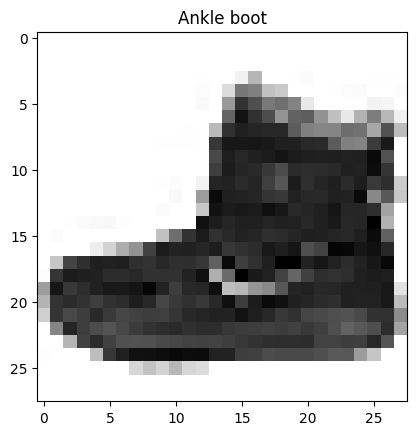

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap='binary') # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(class_names[label]);

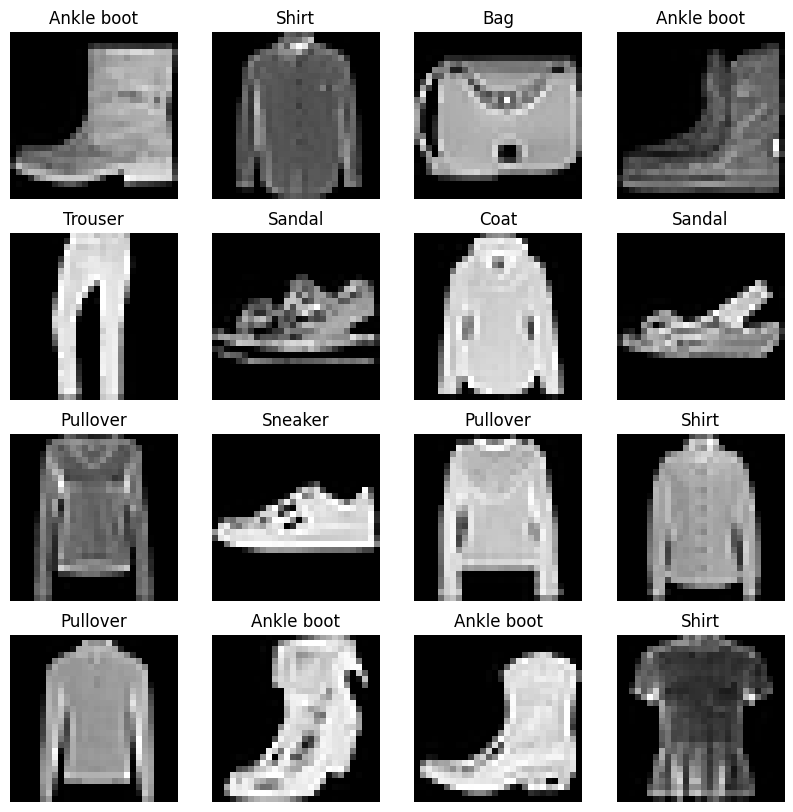

In [9]:
torch.manual_seed(42)
fig=plt.figure(figsize=(10,10))
rows,cols=4,4
for i in range(1,rows*cols+1):
    random_idx=torch.randint(0,len(train_data), size=[1]).item()
    img,label=train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001AAB0279640>, <torch.utils.data.dataloader.DataLoader object at 0x000001AA89AC03D0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
train_batch,label_batch=next(iter(train_dataloader))
train_batch.shape,label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [13]:
class BaseFashionModel(nn.Module):
    def __init__(self,input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            
            nn.Linear(in_features=hidden_units,out_features=output_shape),
        )
        
    def forward(self,x):
        return self.layer_stack(x)
    
        

In [14]:
torch.manual_seed(42)
model=BaseFashionModel(
    784,10,len(class_names)
)
model.to('cpu')

BaseFashionModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [16]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(params=model.parameters(),lr=0.1)
acc_fn=torchmetrics.Accuracy('multiclass',num_classes=len(class_names))

In [17]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [18]:
from tqdm.auto import tqdm
torch.manual_seed(42)

train_time_start_on_cpu = timer()

epochs=3

for epoch in range(epochs):
    train_loss=0
    train_acc=0
    for batch, (X,y) in enumerate(train_dataloader):
        model.train()

        y_pred=model(X)
        loss=loss_fn(y_pred,y)
    
        train_loss+=loss
        train_acc+=acc_fn(y_pred.argmax(dim=1),y)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
    train_loss /= len(train_dataloader)
    train_acc /=len(train_dataloader)
    
    test_loss,test_acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            test_pred=model(X)
            test_loss+=loss_fn(test_pred,y)
            test_acc+=acc_fn(test_pred.argmax(dim=1),y)
    
        test_loss /= len(test_dataloader)
        test_acc /=len(test_dataloader)      
    
    print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc*100:.2f}%\n | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")
        
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))    


Train loss: 2.89337, Train acc: 70.13%
 | Test loss: 1.76363, Test acc: 75.28%


Train loss: 3.84353, Train acc: 72.58%
 | Test loss: 2.37558, Test acc: 74.50%


Train loss: 3.34465, Train acc: 73.70%
 | Test loss: 2.20361, Test acc: 74.56%

Train time on cpu: 82.833 seconds


In [19]:
import torch.utils
import torch.utils.data


torch.manual_seed(42)
def eval_model(model: nn.Module, data_loader: torch.utils.data.DataLoader,loss_fn:nn.Module, accuracy_fn):
    loss,acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred=model(X)
            loss+=loss_fn(y_pred,y)
            acc+=accuracy_fn(y_pred.argmax(dim=1),y)
            
        loss/=len(data_loader)
        acc/=len(data_loader)
        
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}


In [ ]:

model_results=eval_model(model=model,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=acc_fn)
model_results

In [21]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [22]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names) 
).to(device) 
next(model_1.parameters()).device 

device(type='cuda', index=0)

In [46]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(params=model.parameters(),lr=0.1)
acc_fn=torchmetrics.Accuracy('multiclass',num_classes=len(class_names)).to(device)

In [55]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1),y) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1),y)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [53]:
acc_fn.device

device(type='cuda', index=0)

In [56]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()



epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30166 | Train accuracy: 0.11%
Test loss: 2.30211 | Test accuracy: 0.11%

Epoch: 1
---------
Train loss: 2.30166 | Train accuracy: 0.11%
Test loss: 2.30211 | Test accuracy: 0.11%

Epoch: 2
---------
Train loss: 2.30166 | Train accuracy: 0.11%
Test loss: 2.30211 | Test accuracy: 0.11%

Train time on cuda: 47.917 seconds


In [26]:
model_1_results=eval_model(model_1,test_dataloader,loss_fn,acc_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 2.3021068572998047,
 'model_acc': 10.7527956366539}

In [61]:
class FashionMNISTModel(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) # default stride value is same as kernel_size
        )
        self.block2=nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7,out_features=output_shape)
        )
        
    def forward(self,x:torch.Tensor):
        return self.classifier(self.block2(self.block1(x)))
    

In [62]:
cmodel=FashionMNISTModel(1,10,len(class_names)).to(device)
cmodel

FashionMNISTModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [63]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(params=cmodel.parameters(),lr=0.01)
acc_fn=torchmetrics.Accuracy('multiclass',num_classes=len(class_names)).to(device)

In [64]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=cmodel, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cmodel,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.52795 | Train accuracy: 0.81%
Test loss: 0.41055 | Test accuracy: 0.85%

Epoch: 1
---------
Train loss: 0.39730 | Train accuracy: 0.86%
Test loss: 0.40040 | Test accuracy: 0.85%

Epoch: 2
---------
Train loss: 0.37620 | Train accuracy: 0.86%
Test loss: 0.40540 | Test accuracy: 0.85%

Train time on cuda: 61.090 seconds


In [65]:
model_2_results = eval_model(
    model=cmodel,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=acc_fn
)
model_2_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.40539899468421936,
 'model_acc': 85.47323942184448}

In [66]:
def make_predictions(model:nn.Module,data:list, device=device):
    pred_probs=[]
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample=torch.unsqueeze(sample,dim=0).to(device)
            pred_logit=model(sample)
            pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
    
    return torch.stack(pred_probs)

In [67]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [68]:
pred_probs=make_predictions(cmodel,test_samples)


In [69]:
pred_classes=pred_probs.argmax(dim=1)
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 2, 3, 0, 4, 7, 1]))

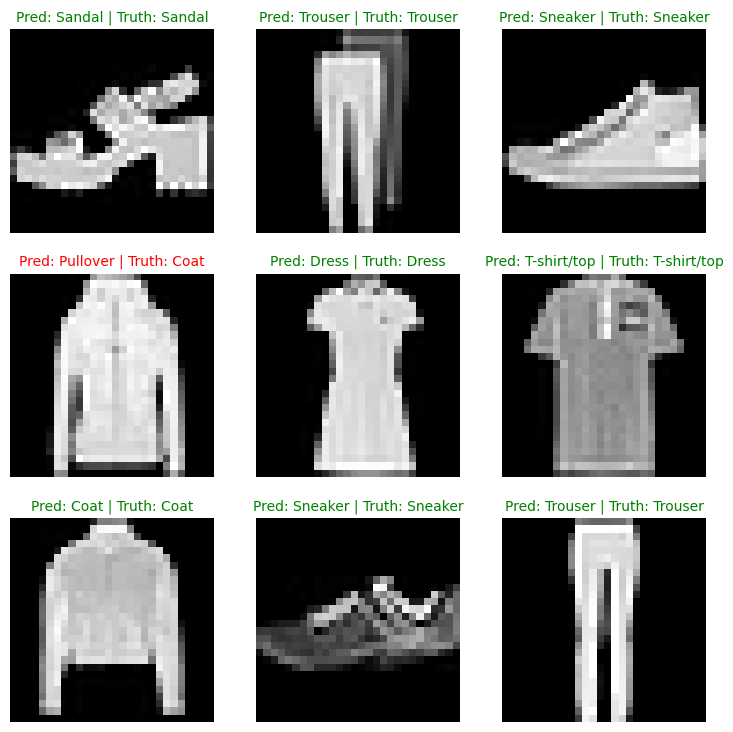

In [70]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [71]:
y_preds=[]
cmodel.eval()
with torch.inference_mode():
    for X,y in test_dataloader:
        X,y=X.to(device),y.to(device)
        
        y_logits=cmodel(X)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        
y_pred_tensor=torch.cat(y_preds)

In [73]:

cm=torchmetrics.ConfusionMatrix(num_classes=len(class_names),task='multiclass')(preds=y_pred_tensor,target=test_data.targets)

cm

tensor([[835,   1,  12,  22,   9,   1, 113,   0,   7,   0],
        [  7, 953,   0,  28,   3,   0,   7,   0,   2,   0],
        [  8,   2, 665,  11, 215,   0,  98,   0,   1,   0],
        [ 34,   3,   9, 858,  63,   0,  30,   0,   2,   1],
        [  2,   0,  78,  17, 851,   0,  52,   0,   0,   0],
        [  0,   0,   1,   0,   0, 943,   0,  36,   2,  18],
        [151,   2,  67,  33, 155,   0, 583,   0,   9,   0],
        [  0,   0,   0,   0,   0,  12,   0, 973,   0,  15],
        [  4,   1,   5,   5,   7,   3,  30,   6, 937,   2],
        [  0,   0,   1,   0,   0,   6,   0,  44,   1, 948]])